<a href="https://colab.research.google.com/github/colawhite/AllstateStudyGrp/blob/master/Spacy_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/
# https://github.com/skipgram/modern-nlp-in-python/blob/master/executable/Modern_NLP_in_Python.ipynb
# https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/

Best practice (ref: https://groups.google.com/forum/#!topic/gensim/MgHwMJSX2t0)

1. Lower case all words and clear texts from punctuation
2. Remove stopwords
3. Remove words with a length below 3 characters
4. Lemmatize words
5. Remove words with a length below 3 characters (again, as for example 'doing' will now be 'do' after step 4)
6. Create bigrams via Phrases method (first train it on the texts after step 5 and then apply it to those texts)
7. Prune the dictionary from high frequency words (words that occur in over 95% of the documents) and then prune the texts by excluding those words from the text
8. Create the corpus

In [113]:
# install library
#!pip install spacy
#!pip install textacy
#!pip install pyLDAvis
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

ERROR! Session/line number was not unique in database. History logging moved to new session 61
     |████████████████████████████████| 1.6MB 3.5MB/s 
     |████████████████████████████████| 552kB 15.5MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97711 sha256=2a64ba336d23329bc2fd2481cef37ee67581cecef8c755399ab5bd39c2213e3c
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
  Created wheel for funcy: filename=funcy-1.14-py2.py3-none-any.whl size=32042 sha256=c2904f6722c677f5983151698ce0ad06826db0a05bd1f69334cf62585623b416
  Stored in directory: /root/.cache/pip/wheels/20/5a/d8/1d875df03deae6f178dfdf70238cca33f948ef8a6f5209f2eb
Successfully built pyLDAvis funcy


In [0]:
# required library
import re
import textacy
import pyLDAvis.gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
import seaborn as sns
import gensim
import spacy
import pandas as pd
import wordcloud
from wordcloud import WordCloud
from collections import Counter
from spacy.lang.es.stop_words import STOP_WORDS
import nltk
import matplotlib.pyplot as plt
nlp = spacy.load('en',parser=False, entity=False)

In [0]:
# use spacy for preprocessing and lemmatization, keep gensim simple_preprocess as reference
#def preprocess(sentences):
#    for sent in sentences:
#        sent = re.sub('\s+', ' ', sent)  # remove newline chars
#        sent = re.sub("\'", "", sent)  # remove single quotes
#        sent = gensim.utils.simple_preprocess(str(sent), deacc=True,min_len=3) #deacc = True: remove token mark
#    return sent

In [0]:
doc = ["i don't play 33 the basketball in Los Angeles. toy story 4 is my top-notch movie in Los Angeles!"]
#print (preprocess(doc))

In [73]:
parsed=nlp(doc[0])
print (parsed)
for num, entity in enumerate(parsed.ents):
    print ('Entity {}:'.format(num + 1), entity, '-', entity.label)
spacy.displacy.render(parsed, style = "ent",jupyter = True)

i don't play 33 the basketball in Los Angeles. toy story 4 is my top-notch movie in Los Angeles!
Entity 1: 33 - 397
Entity 2: Los Angeles - 384
Entity 3: Los Angeles - 384


In [74]:
token_text = [token.orth_ for token in parsed]
token_pos = [token.pos_ for token in parsed]
token_lemma = [token.lemma_ for token in parsed]
token_prob = [token.prob for token in parsed]
token_is_stop = [token.is_stop for token in parsed]
token_is_punct = [token.is_punct for token in parsed]
token_like_num = [token.like_num for token in parsed]
pd.DataFrame(zip(token_text, token_pos,token_lemma,token_prob,token_is_stop,token_is_punct,token_like_num),
             columns=['token_text', 'part_of_speech','token_lemma','token_prob','is_stop?','is_punct?','likenum'])

,token_text,part_of_speech,token_lemma,token_prob,is_stop?,is_punct?,likenum
0,i,PRON,i,-20.0,True,False,False
1,do,AUX,do,-20.0,True,False,False
2,n't,PART,not,-20.0,True,False,False
3,play,VERB,play,-20.0,False,False,False
4,33,NUM,33,-20.0,False,False,True
5,the,DET,the,-20.0,True,False,False
6,basketball,NOUN,basketball,-20.0,False,False,False
7,in,ADP,in,-20.0,True,False,False
8,Los,PROPN,Los,-20.0,False,False,False
9,Angeles,PROPN,Angeles,-20.0,False,False,False


In [75]:
df = pd.DataFrame(zip(token_text, token_pos,token_lemma,token_prob,token_is_stop,token_is_punct,token_like_num),
             columns=['token_text', 'part_of_speech','token_lemma','token_prob','is_stop','is_punct?','likenum'])
token = list(df[(df.part_of_speech!='PUNCT') & (df.is_stop==False)].token_lemma)
print (token)
# add entities, remove partial entities
for entity in parsed.ents:
    n = len(entity)
    for i in range(n):
        if str(entity[i]) in token: token.remove(str(entity[i])) 
    if str(entity) not in token:
        token += [str(entity)]
print (token)

['play', '33', 'basketball', 'Los', 'Angeles', 'toy', 'story', '4', 'notch', 'movie', 'Los', 'Angeles']
['play', 'basketball', 'toy', 'story', '4', 'notch', 'movie', '33', 'Los Angeles']


In [76]:
# add ngram using textacy
print (doc[0])
bigram_obj = textacy.make_spacy_doc(doc[0], lang='en_core_web_sm')
for bigram in list(textacy.extract.ngrams(bigram_obj,2)):
    if str(bigram) not in token: token.append(str(bigram))
print (token)

i don't play 33 the basketball in Los Angeles. toy story 4 is my top-notch movie in Los Angeles!
['play', 'basketball', 'toy', 'story', '4', 'notch', 'movie', '33', 'Los Angeles', 'play 33', 'toy story', 'story 4', 'notch movie']


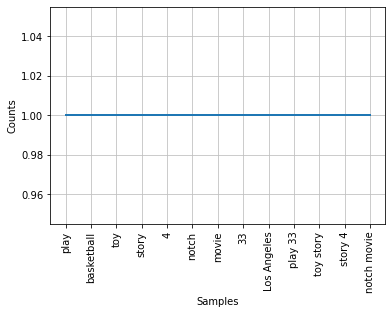

{'play': 1, 'basketball': 1, 'toy': 1, 'story': 1, '4': 1, 'notch': 1, 'movie': 1, '33': 1, 'Los Angeles': 1, 'play 33': 1, 'toy story': 1, 'story 4': 1, 'notch movie': 1}


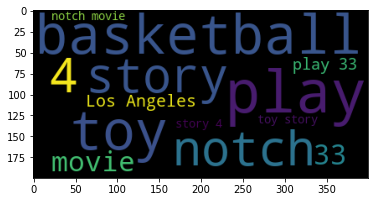

In [81]:
fd=nltk.FreqDist(token)
fd.plot()
print(dict(fd))
wordcloud = WordCloud(relative_scaling=1.0).generate_from_frequencies(dict(fd)) 
plt.imshow(wordcloud)

In [93]:
# lemmatization
token_join = u' '.join(token)
data_ready = [token]
print (data_ready)

[['play', 'basketball', 'toy', 'story', '4', 'notch', 'movie', '33', 'Los Angeles', 'play 33', 'toy story', 'story 4', 'notch movie']]


In [94]:
# create corpus
id2word = corpora.Dictionary(data_ready)
print (len(data_ready))
print (len(id2word)) # 10 unique id
print(id2word)
corpus = [id2word.doc2bow(text) for text in data_ready]
print (corpus)

1
13
Dictionary(13 unique tokens: ['33', '4', 'Los Angeles', 'basketball', 'movie']...)
[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1)]]


In [95]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus]

[[('33', 1),
  ('4', 1),
  ('Los Angeles', 1),
  ('basketball', 1),
  ('movie', 1),
  ('notch', 1),
  ('notch movie', 1),
  ('play', 1),
  ('play 33', 1),
  ('story', 1),
  ('story 4', 1),
  ('toy', 1),
  ('toy story', 1)]]

In [0]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=3, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

In [100]:
sent_topics_df = pd.DataFrame()
for i, row_list in enumerate(lda_model[corpus]): 
    #if i == 5: break
    row = row_list[0] if lda_model.per_word_topics else row_list 
    row = sorted(row, key=lambda x: (x[1]), reverse=True) # sort by probability
    #print (i,row_list) # 0 ([(0, 0.12504743), (1, 0.12505735), (2, 0.62483203), (3, 0.12506321)], [(0, [2])], [(0, [(2, 0.99966407)])])
    #print ('*')
    #print (row) # [(0, 0.12504743), (1, 0.12505735), (2, 0.62483203), (3, 0.12506321)]
    #print ('*'*2)
    for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = lda_model.show_topic(topic_num) 
                #print (wp) # [('god', 0.045394894), ('hayward', 0.03953819), ('jonathan', 0.039538156), ('greatest', 0.03808196), ('strength', 0.038081944), ('give', 0.03808194), ('climbing', 0.03808189), ('important', 0.03746834), ('cords', 0.031485148), ('infinite', 0.031484917)]
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
sent_topics_df.head()

,Dominant_Topic,Perc_Contribution,Topic_Keywords
0,0.0,0.9508,"toy story, play 33, notch, basketball, story, ..."


In [101]:
topics = lda_model.show_topics(formatted=False)
print (topics)

[(0, [('toy story', 0.076947615), ('play 33', 0.07694121), ('notch', 0.076931715), ('basketball', 0.07693125), ('story', 0.0769276), ('Los Angeles', 0.07692552), ('story 4', 0.076925345), ('4', 0.076924674), ('movie', 0.07692198), ('play', 0.07691896)]), (1, [('33', 0.07705096), ('toy', 0.07700764), ('notch movie', 0.0769618), ('play', 0.07694236), ('movie', 0.076926254), ('Los Angeles', 0.076917455), ('4', 0.076913185), ('story 4', 0.07691053), ('story', 0.076904364), ('basketball', 0.07689349)]), (2, [('toy', 0.07692899), ('4', 0.07692659), ('story 4', 0.076926574), ('notch movie', 0.0769244), ('movie', 0.07692425), ('notch', 0.076924205), ('story', 0.076923795), ('33', 0.07692355), ('play 33', 0.07692246), ('basketball', 0.07692013)])]


NameError: ignored

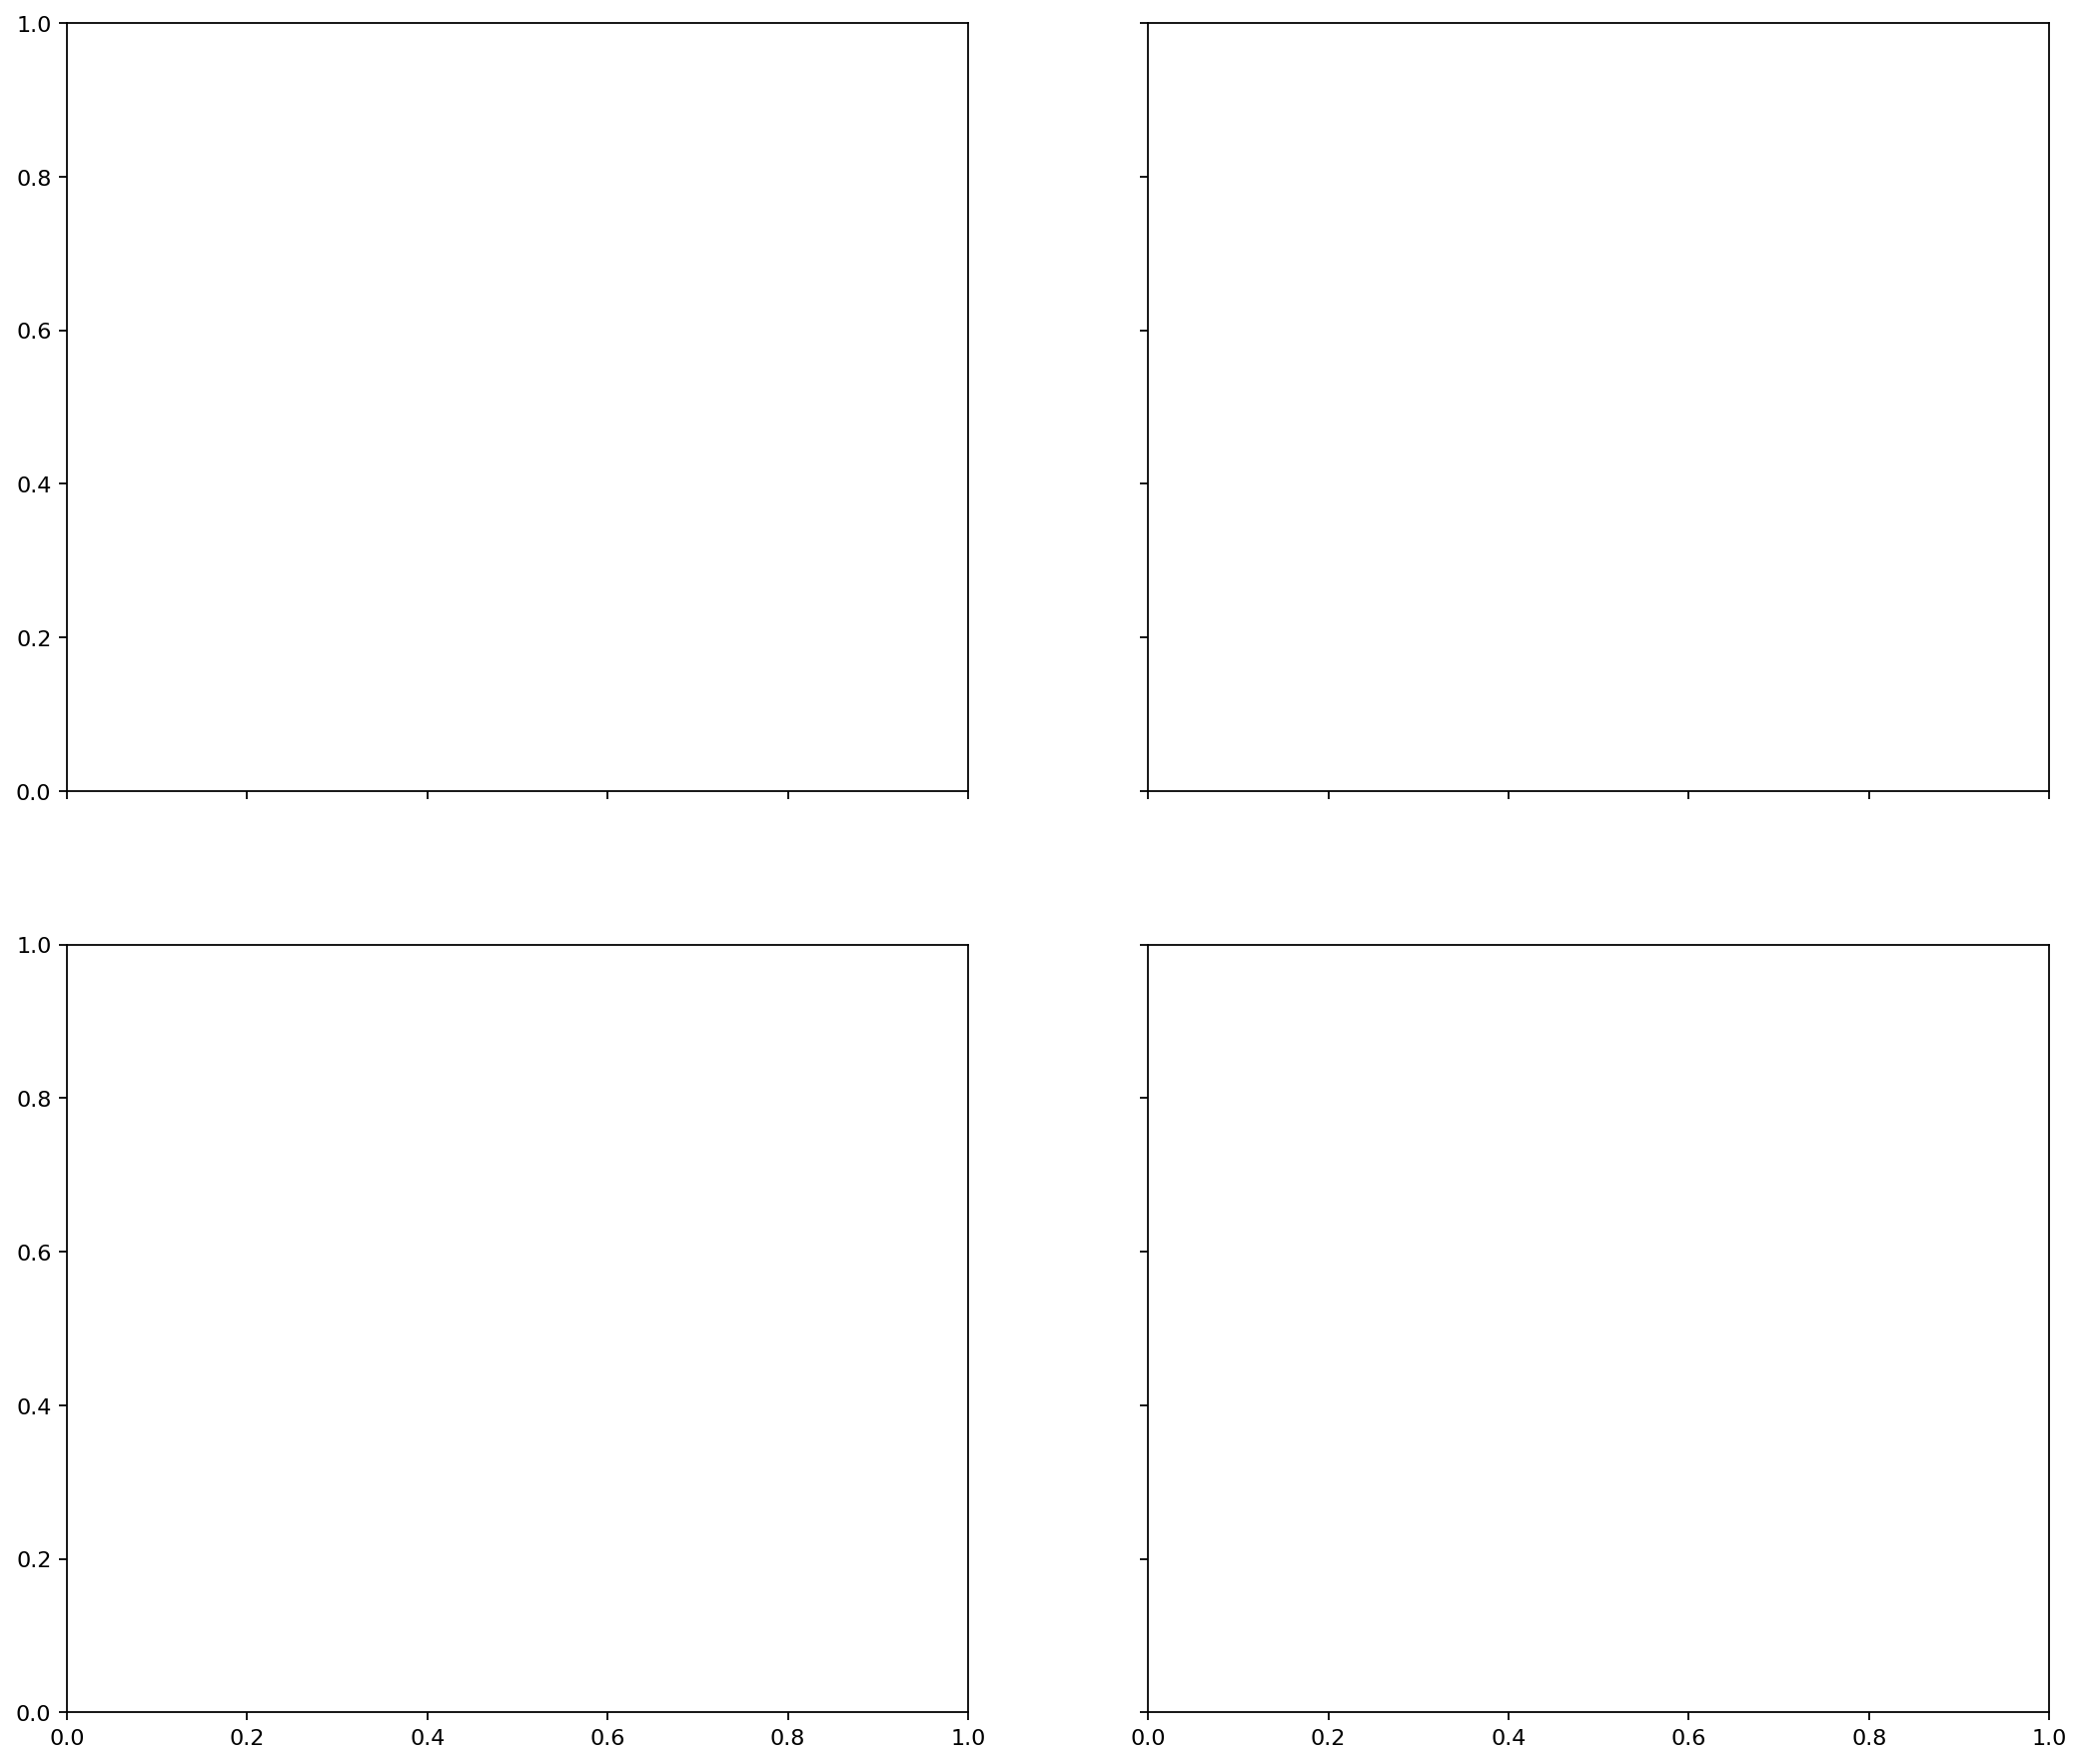

In [116]:
# only work for 4 topics
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

TypeError: ignored

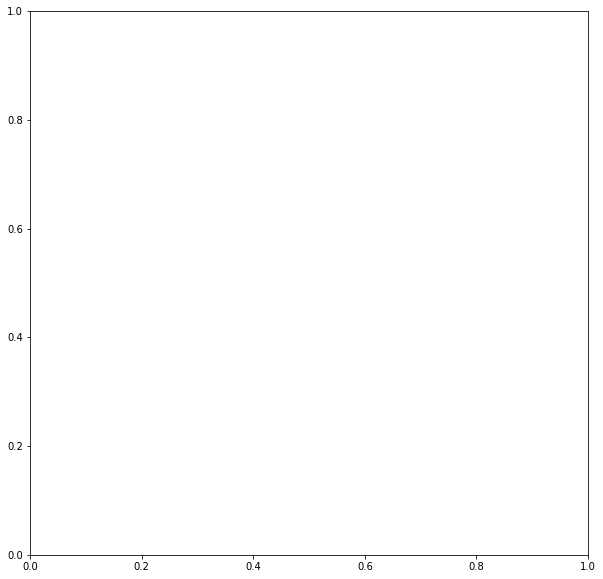

In [105]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

fig, axes = plt.subplots(1, 1, figsize=(10,10), sharex=True, sharey=True)
cloud = WordCloud(
                  background_color='black',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  #color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

#for i, ax in enumerate(axes.flatten()):
for i, ax in enumerate(axes):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')

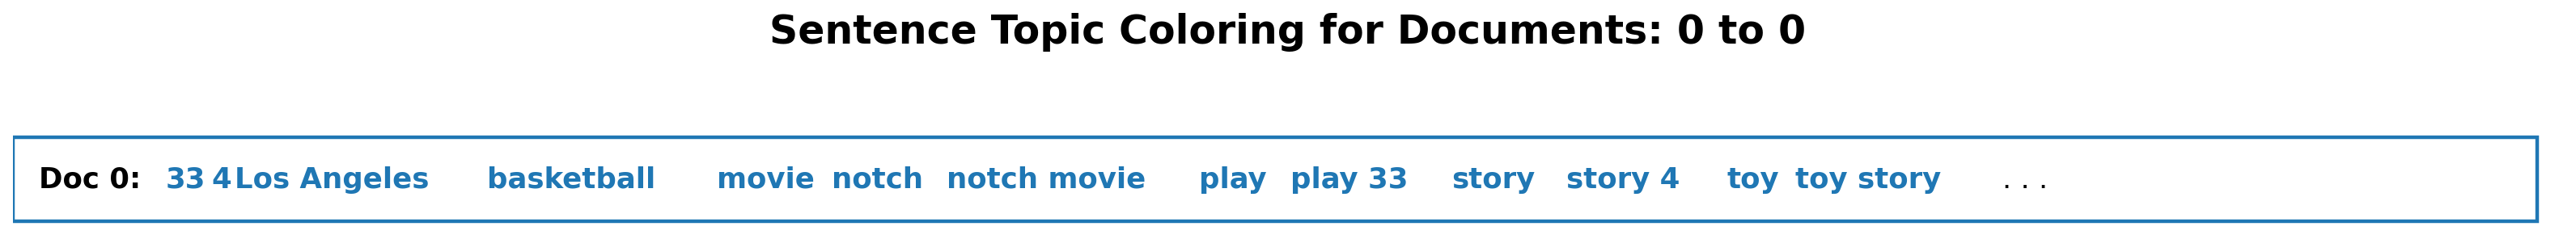

In [120]:
# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda_model, corpus=corpus, start = 0, end = 2):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart()  

In [110]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=token, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -3.5653519859680762

Coherence Score:  nan


/usr/local/lib/python3.6/dist-packages/gensim/topic_coherence/direct_confirmation_measure.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
/usr/local/lib/python3.6/dist-packages/gensim/topic_coherence/indirect_confirmation_measure.py:317: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


In [115]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/usr/local/lib/python3.6/dist-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=         x    y  topics  cluster       Freq
topic                                      
0     -0.0 -0.0       1        1  95.083359
1      0.0 -0.0       2        1   2.458551
2      0.0  0.0       3        1   2.458092, topic_info=   Category      Freq         Term     Total  loglift  logprob
0   Default  0.000000           33  0.000000  13.0000  13.0000
11  Default  0.000000          toy  0.000000  12.0000  12.0000
6   Default  0.000000  notch movie  0.000000  11.0000  11.0000
7   Default  0.000000         play  0.000000  10.0000  10.0000
4   Default  0.000000        movie  0.000000   9.0000   9.0000
1   Default  1.000000            4  1.000000   8.0000   8.0000
10  Default  1.000000      story 4  1.000000   7.0000   7.0000
2   Default  1.000000  Los Angeles  1.000000   6.0000   6.0000
9   Default  1.000000        story  1.000000   5.0000   5.0000
3   Default  1.000000   basketball  1.000000   4.0000   4.0000
5   Default  1.000000        notch  1.000000   3.0000   3.0000
8   Default  1.000000      play 33  1.000000   2.0000   2.0000
12  Default  1.000000    toy story  1.000000   1.0000   1.0000
12   Topic1  0.951137    toy story  1.000272   0.0000  -2.5646
8    Topic1  0.951058      play 33  1.000201   0.0000  -2.5647
5    Topic1  0.950940        notch  1.000096   0.0000  -2.5648
3    Topic1  0.950935   basketball  1.000091   0.0000  -2.5648
9    Topic1  0.950889        story  1.000050   0.0000  -2.5649
2    Topic1  0.950864  Los Angeles  1.000027   0.0000  -2.5649
10   Topic1  0.950862      story 4  1.000025   0.0000  -2.5649
1    Topic1  0.950853            4  1.000018   0.0000  -2.5649
4    Topic1  0.950820        movie  0.999988  -0.0000  -2.5650
7    Topic1  0.950783         play  0.999954  -0.0000  -2.5650
6    Topic1  0.950709  notch movie  0.999888  -0.0000  -2.5651
11   Topic1  0.950552          toy  0.999747  -0.0000  -2.5652
0    Topic1  0.950434           33  0.999641  -0.0001  -2.5654
0    Topic2  0.024626           33  0.999641   0.0020  -2.5633
11   Topic2  0.024613          toy  0.999747   0.0014  -2.5639
6    Topic2  0.024598  notch movie  0.999888   0.0006  -2.5644
7    Topic2  0.024592         play  0.999954   0.0003  -2.5647
4    Topic2  0.024587        movie  0.999988   0.0001  -2.5649
2    Topic2  0.024584  Los Angeles  1.000027  -0.0001  -2.5650
1    Topic2  0.024582            4  1.000018  -0.0001  -2.5651
10   Topic2  0.024582      story 4  1.000025  -0.0002  -2.5651
9    Topic2  0.024580        story  1.000050  -0.0003  -2.5652
3    Topic2  0.024576   basketball  1.000091  -0.0005  -2.5653
5    Topic2  0.024574        notch  1.000096  -0.0006  -2.5654
8    Topic2  0.024563      play 33  1.000201  -0.0011  -2.5659
12   Topic2  0.024557    toy story  1.000272  -0.0014  -2.5661
0    Topic3  0.024581           33  0.999641   0.0004  -2.5649
11   Topic3  0.024583          toy  0.999747   0.0003  -2.5649
6    Topic3  0.024581  notch movie  0.999888   0.0001  -2.5649
1    Topic3  0.024582            4  1.000018   0.0000  -2.5649
4    Topic3  0.024581        movie  0.999988   0.0000  -2.5649
10   Topic3  0.024582      story 4  1.000025   0.0000  -2.5649
7    Topic3  0.024580         play  0.999954   0.0000  -2.5650
9    Topic3  0.024581        story  1.000050  -0.0000  -2.5649
2    Topic3  0.024580  Los Angeles  1.000027  -0.0001  -2.5650
5    Topic3  0.024581        notch  1.000096  -0.0001  -2.5649
3    Topic3  0.024580   basketball  1.000091  -0.0001  -2.5650
8    Topic3  0.024581      play 33  1.000201  -0.0002  -2.5650
12   Topic3  0.024579    toy story  1.000272  -0.0004  -2.5650, token_table=      Topic      Freq         Term
term                              
0         1  1.000359           33
1         1  0.999982            4
2         1  0.999973  Los Angeles
3         1  0.999909   basketball
4         1  1.000012        movie
5         1  0.999904        notch
6         1  1.000112  notch movie
7         1  1.000046         play
8         1  0.999799      play 33


In [0]:
# To Do: find the optimal topic number
#My approach to finding the optimal number of topics is to build many LDA models with different values of number of topics (k) and pick the one that gives the highest coherence value.

#Choosing a ‘k’ that marks the end of a rapid growth of topic coherence usually offers meaningful and interpretable topics. Picking an even higher value can sometimes provide more granular sub-topics.

#If you see the same keywords being repeated in multiple topics, it’s probably a sign that the ‘k’ is too large.

#The compute_coherence_values() (see below) trains multiple LDA models and provides the models and their corresponding coherence scores.